# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import math
import random
import traceback
import sqlite3
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.metrics import make_scorer
from scipy.stats import uniform
from scipy.sparse import find
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [4]:


final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

# Text Preprocessing: Stemming, stop-word removal and Lemmatization

In [5]:
import nltk
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [6]:
import re
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [7]:

final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
288755,7137,7802,B00474H936,A2JT9TJ74UYK30,Laura,2,2,positive,1336435200,Meaty texture,Very meaty texture for a vegetarian product. ...,meati textur vegetarian product look like fres...
20630,479208,518195,B001E5E3LW,A156JLBSURBJE3,"R. Corcoran ""barryvillage2""",4,5,positive,1198627200,barryvillage2,As a sugar substitute this product is great. ...,sugar substitut product great wish product wou...
190985,210138,227746,B0033HPPIO,A3FLZCOLQMZ6J1,MrsKaraT,0,0,positive,1314144000,My husband loves this Kcup!,My husband is the big coffee drinker around th...,husband big coffe drinker around hous hes one ...
125128,140196,152146,B0002EOW4E,A1NE4STC8I0T6D,Jana Dengler,0,7,negative,1291075200,Tripett green tripe?,Disappointed to find meat by products in what ...,disappoint find meat product thought suppos gr...
142392,9789,10707,B00389Q4XW,A23CDAI9ZJWVKO,Elaine,0,0,positive,1297555200,I love CocoaWhen I,When I got my coffee maker there were only two...,got coffe maker two cocoa cup mix coffe deligh...


In [8]:
n_samples = 25000
final = final.sample(n_samples)

###Sorting as we want according to time series
final.sort_values('Time',inplace=True) 
final.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
9,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...
21,138018,149790,B00004S1C6,A1IU7S4HCK1XK0,Joanna Daneman,25,27,positive,982800000,Make your own Martha Stewart style cakes and c...,I don't know why anyone would ever use those l...,dont know anyon would ever use littl liquid fo...
34,346113,374419,B00004CI84,ADIDQRLLR4KBQ,"""paradise_found""",2,2,positive,1015545600,Because My Middle Name is &quot;Weird&quot;,"Set in a small New England town, Tim Burton's ...",set small new england town tim burton masterpi...
69,420194,454404,B007JXVR76,A1ZXF1MOZZYAJC,"""boycat""",0,6,positive,1058313600,Meow Mix is the best cat food in the WORLD!,"I love meow mix, my cats love it to. We all ea...",love meow mix cat love eat togther cat kittl u...
70,388413,419994,B0000A0BS5,A238V1XTSK9NFE,Andrew Lynn,46,59,negative,1064361600,Not actually for use in espresso machines,Few things I'd like to point out:<p>1. &quot;...,thing like point roast drink northern itali ma...
126,444473,480588,B0000CNU51,A4UKBG3M5U5TI,Westley,5,5,positive,1070323200,Surprisingly hot,El Pato Jalape&ntilde;o Salsa is a great tasti...,pato salsa great tast versatil tomato product ...
176,302310,327426,B000100IG0,A39FNCHXMX7DPI,"Stephanie A. Spanbauer ""huszvar""",7,7,positive,1074124800,Chocolate with a PUNCH,These chocolates are the most perfect containe...,chocol perfect contain tasti brandi ever wonde...
217,346051,374354,B00004CI84,A32207GKRIJYDI,Tim Chapin,1,2,positive,1079222400,I can't believe this is Michael Keaton!!!,Beetlejuice is truly a work of art!<br />A bit...,beetlejuic truli work art bit funni bit creepi...
230,405077,438048,B0000DBN2F,AI8905F260S31,Joan Schwartz,5,5,positive,1081296000,The Best Tea,"I have tried many teas in my life , &amp; this...",tri mani tea life far gone top tri differ flav...


In [9]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Bag of Words (BoW) 

In [10]:
x = final['CleanedText'].values
y = final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [11]:
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (17500, 3790)
the number of unique words : 3790


# Random Forest(RF) with GridSearchCV

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))
# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.854847789068937
The optimal number of base learners is :  10
The optimal number of depth is :  120


In [13]:
import seaborn as sns

Best HyperParameter:  {'max_depth': 120, 'n_estimators': 10}
0.8522059515926641


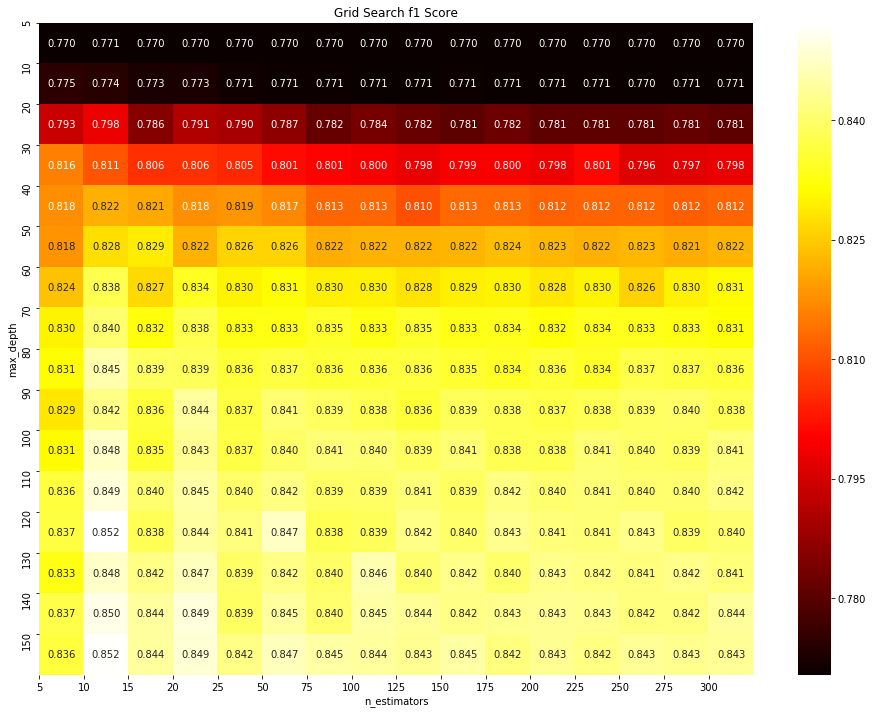

In [14]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

In [15]:
import seaborn as sns

Accuracy of the model at optimal hyperparameter depth = 10 is:  87.773333%
Confusion matrix for the model is:


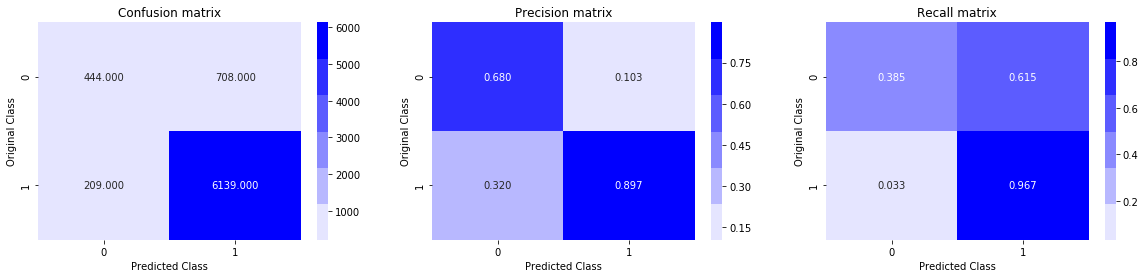

f1 score value for   the model is: 0.8631446618220829
precision score  for   the model is: 0.8965970498028334


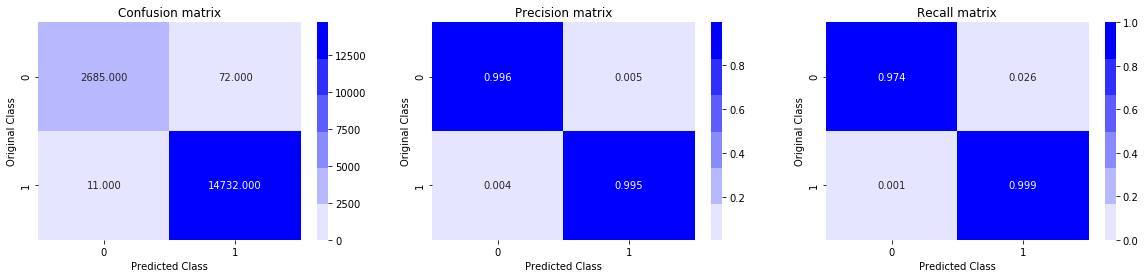

Accuracy of the model at optimal hyperparameter depth = 10 is:  99.525714%
f1 score value for   the model is: 0.9952355106965103
precision score  for   the model is: 0.995136449608214


In [16]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [17]:
# Importing library
from sklearn.ensemble import GradientBoostingClassifier

base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_weighted', cv=3, n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of learning rate
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of max depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=20,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.8733301309514601
The optimal number of base learners is :  300

The optimal value of max depth is :  20


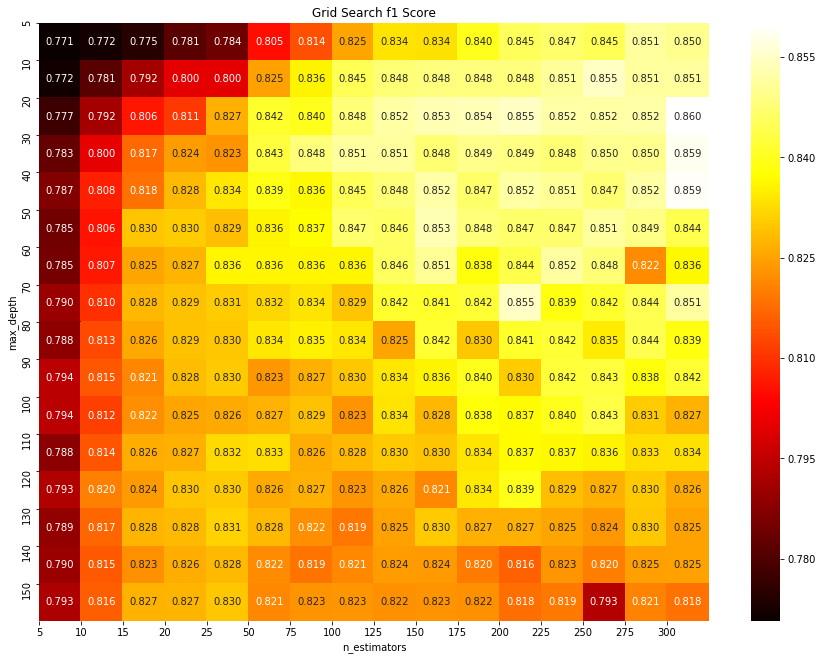

In [18]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(15, 11))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 300 is:  86.960000%
Confusion matrix for the model is:


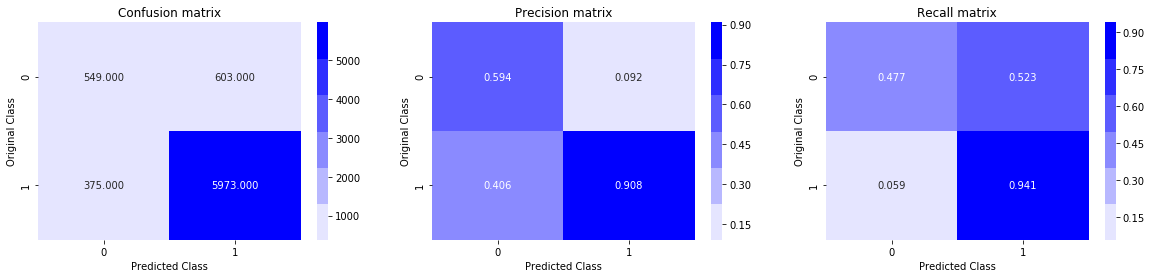

f1 score value for   the model is: 0.8635895384846582
precision score  for   the model is: 0.9083029197080292


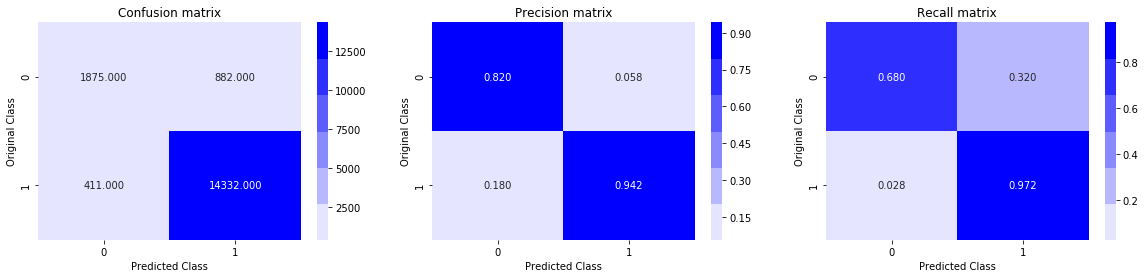

Accuracy of the model at optimal hyperparameter estimator = 300 is:  92.611429%
f1 score value for   the model is: 0.9232447769192669
precision score  for   the model is: 0.9420270803207572


In [19]:
import seaborn as sns
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)






# Term Frequency - Inverse Document Frequency (TF-IDF) 

In [20]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (17500, 3790)
the number of unique words : 3790


# Random Forest(RF) with GridSearchCV

In [21]:


base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=130, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8614202901162389
The optimal number of base learners is :  10
The optimal number of depth is :  130


Best HyperParameter:  {'max_depth': 130, 'n_estimators': 10}
0.8483462681980961


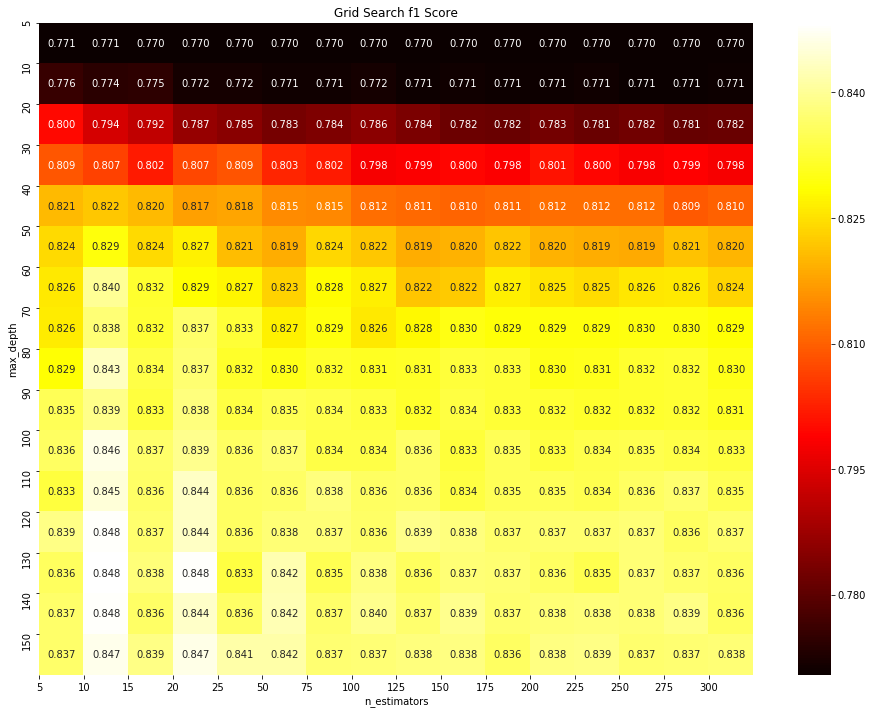

In [22]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter depth = 10 is:  87.946667%
Confusion matrix for the model is:


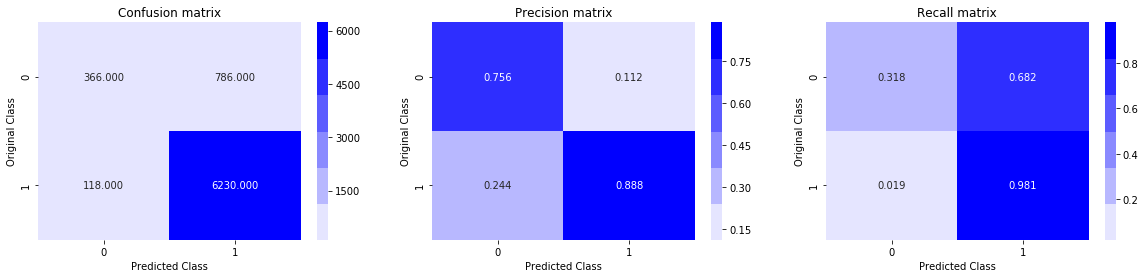

f1 score value for   the model is: 0.8578714371127336
precision score  for   the model is: 0.8879703534777651


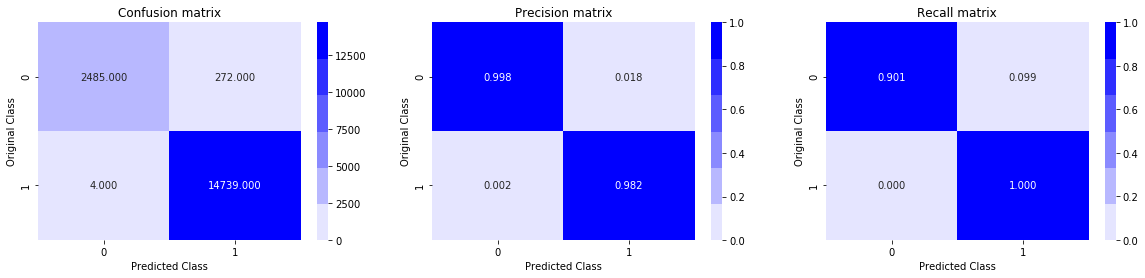

Accuracy of the model at optimal hyperparameter depth = 10 is:  98.422857%
f1 score value for   the model is: 0.9838967456985855
precision score  for   the model is: 0.9818799546998868


In [23]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [24]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=275,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.868906442646433
The optimal number of base learners is :  275

The optimal value of depth is :  10


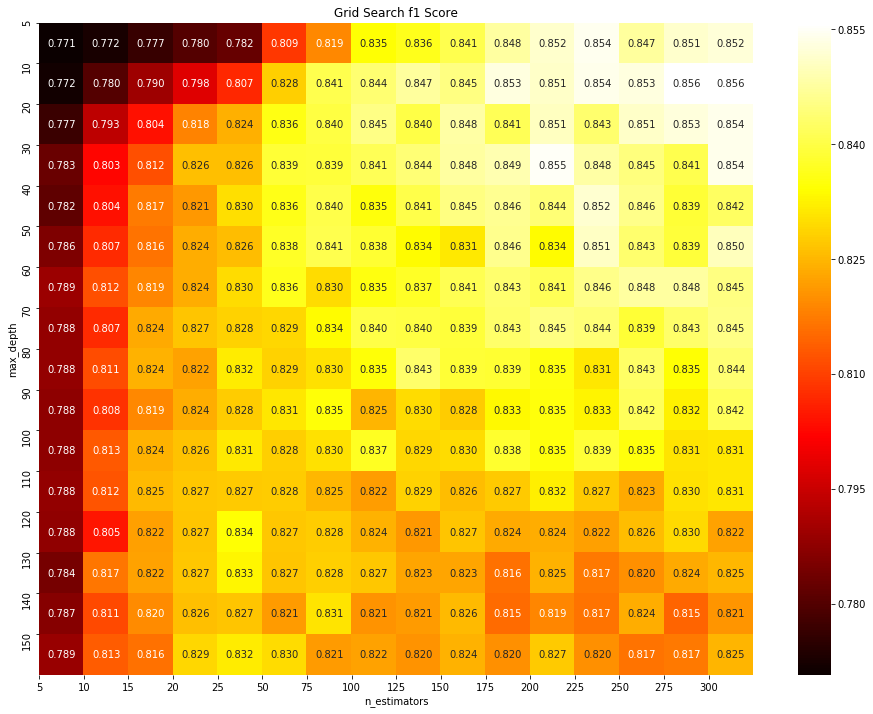

In [25]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 275 is:  88.280000%
Confusion matrix for the model is:


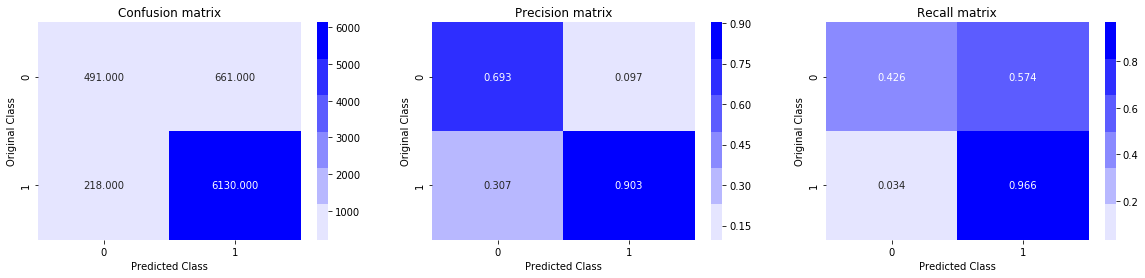

f1 score value for   the model is: 0.8708263999703252
precision score  for   the model is: 0.9026652922986306


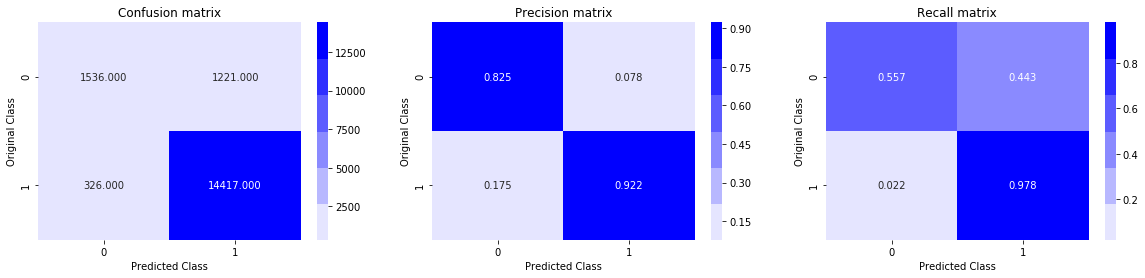

Accuracy of the model at optimal hyperparameter estimator = 275 is:  91.160000%
f1 score value for   the model is: 0.9043376888246839
precision score  for   the model is: 0.9219209617598159


In [26]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# Average Word2Vec

In [27]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  5870


In [28]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    


In [29]:
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
X_train_vec = train_vectors
X_test_vec = test_vectors

# Random Forest(RF) with GridSearchCV

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(max_features=0.2)
model = GridSearchCV(RFC, param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8716000000000002
The optimal number of base learners is :  200
The optimal number of depth is :  80


Best HyperParameter:  {'max_depth': 80, 'n_estimators': 200}
0.8686857142857143


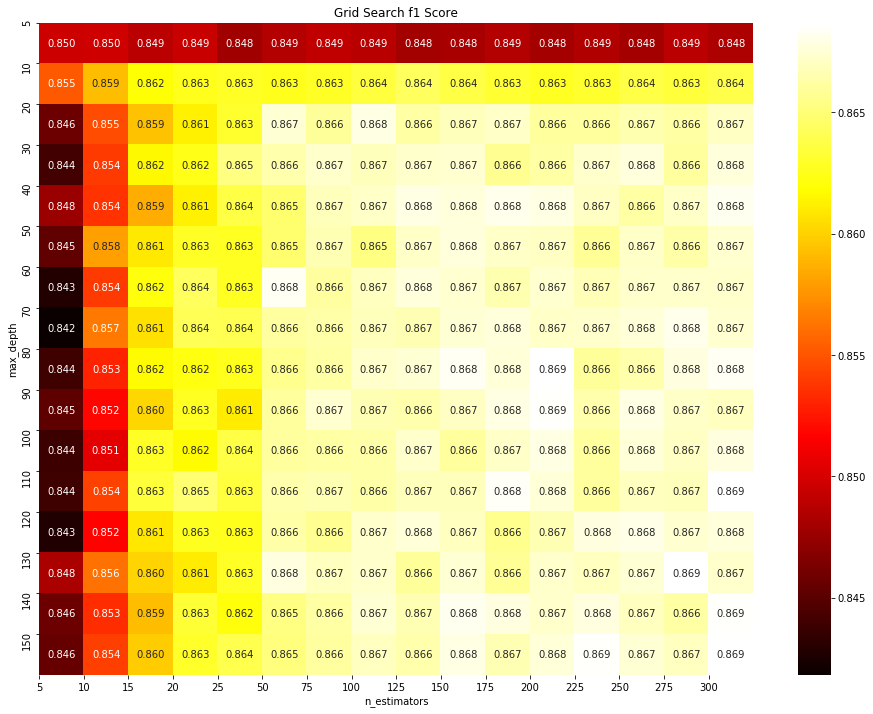

In [32]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter depth = 200 is:  86.840000%
Confusion matrix for the model is:


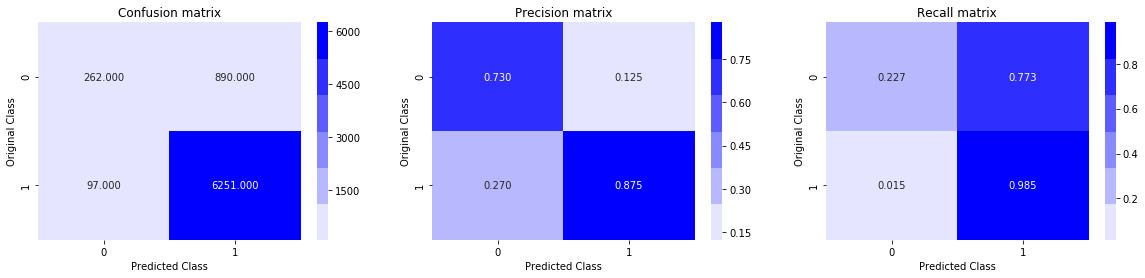

f1 score value for   the model is: 0.8684
precision score  for   the model is: 0.8753675955748494


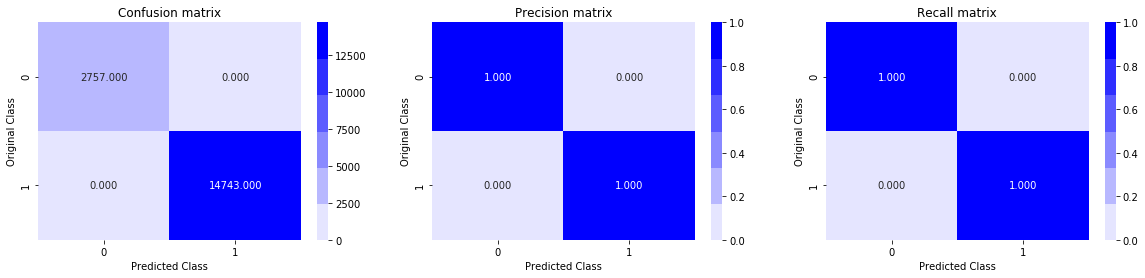

Accuracy of the model at optimal hyperparameter depth = 200 is:  100.000000%
f1 score value for   the model is: 1.0
precision score  for   the model is: 1.0


In [33]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_weighted', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=75,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.8457429290695962
The optimal number of base learners is :  75

The optimal value of depth is :  5


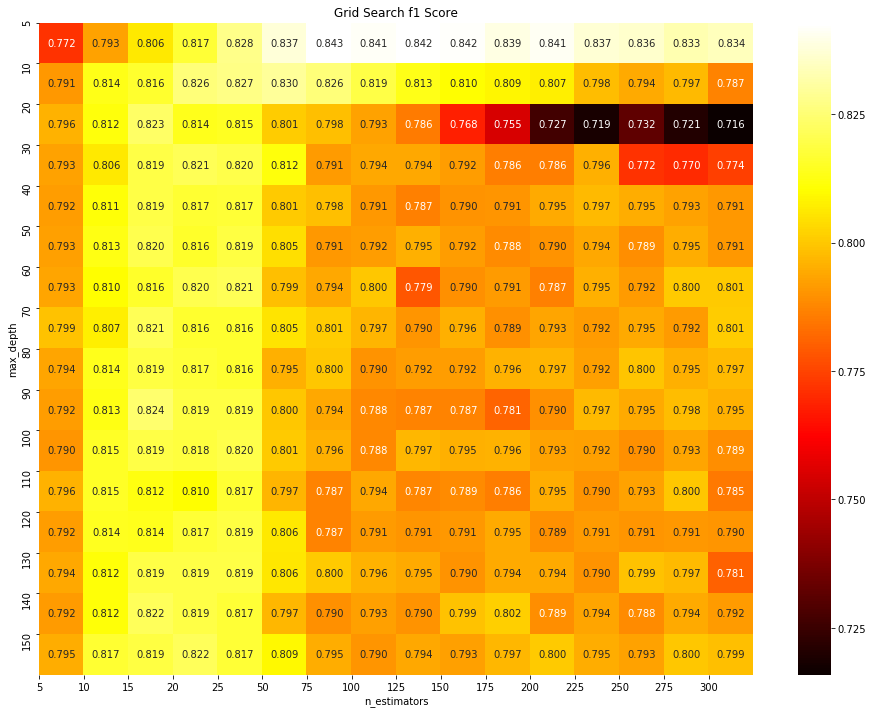

In [35]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 75 is:  86.693333%
Confusion matrix for the model is:


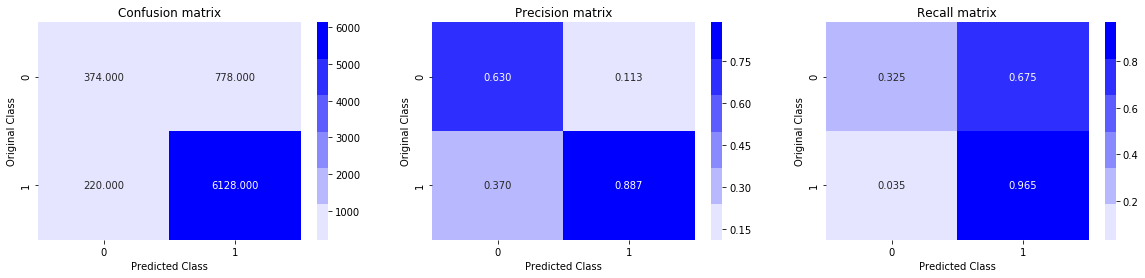

f1 score value for   the model is: 0.8484711895572471
precision score  for   the model is: 0.8873443382565884


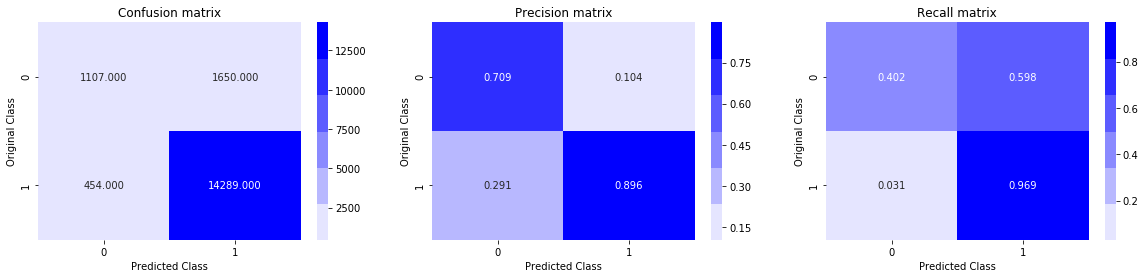

Accuracy of the model at optimal hyperparameter estimator = 75 is:  87.977143%
f1 score value for   the model is: 0.8654642542025487
precision score  for   the model is: 0.8964803312629399


In [36]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# TFIDF-Word2Vec

In [37]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

In [38]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
X_train_vec = tfidf_train_vectors
X_test_vec = tfidf_test_vectors

# Random Forest(RF) with GridSearchCV

In [39]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]

depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
param_grid = {'n_estimators': base_learners,'max_depth': depth}
RFC = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(RFC, param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

optimal_depth=model.best_estimator_.max_depth
print("The optimal number of depth is : ",optimal_depth)

Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=130, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=225, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy of the model :  0.8050666666666666
The optimal number of base learners is :  225
The optimal number of depth is :  130


Best HyperParameter:  {'max_depth': 130, 'n_estimators': 225}
0.8602857142857143


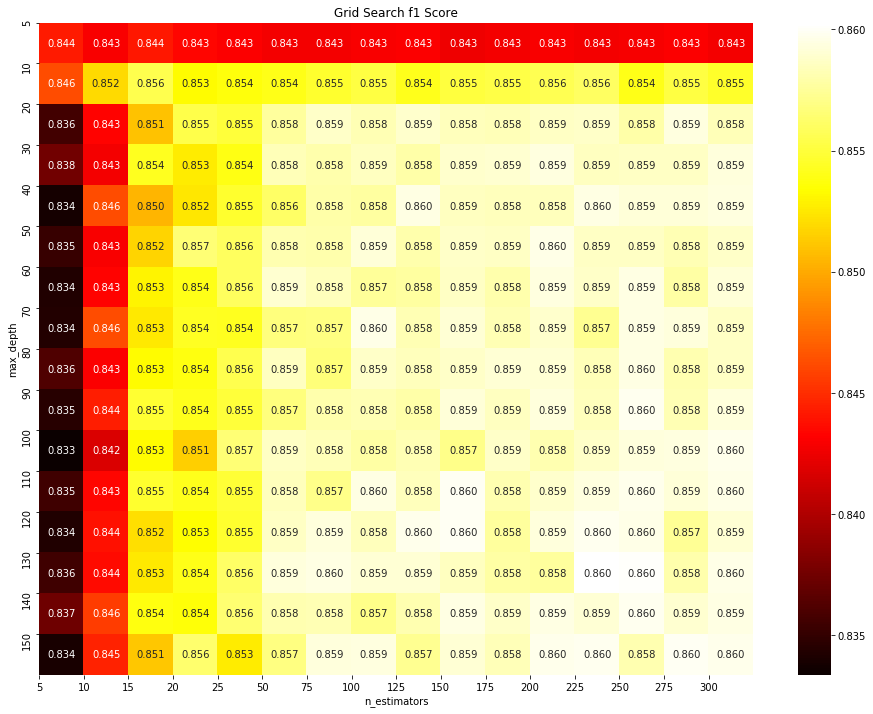

In [40]:
print("Best HyperParameter: ",model.best_params_)
print(model.best_score_)
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter depth = 225 is:  81.026667%
Confusion matrix for the model is:


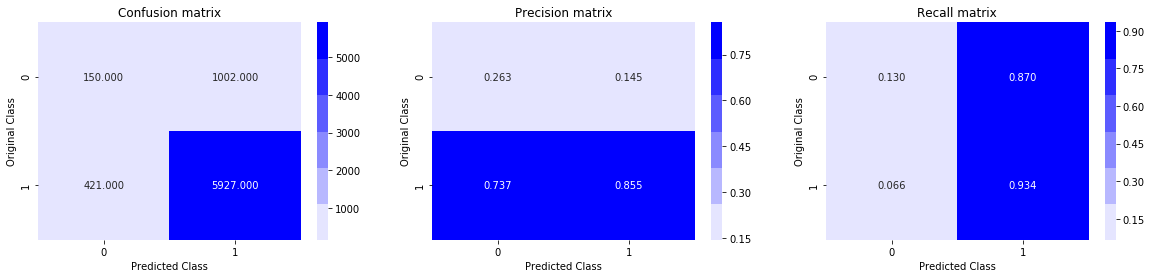

f1 score value for   the model is: 0.8102666666666667
precision score  for   the model is: 0.8553903882234088


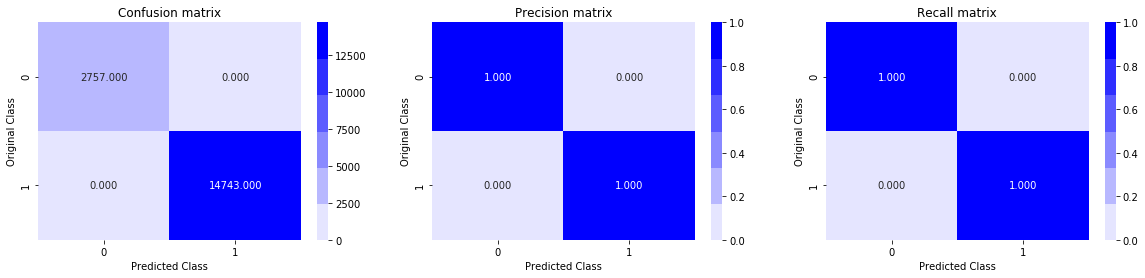

Accuracy of the model at optimal hyperparameter depth = 225 is:  100.000000%
f1 score value for   the model is: 1.0
precision score  for   the model is: 1.0


In [41]:
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
rf = RandomForestClassifier(n_estimators=optimal_learners,max_depth=optimal_depth, max_features='sqrt', n_jobs=-1)
rf.fit(X_train_vec,Y_train)
Y_pred = rf.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = rf.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter depth = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

# Gradient Boosting Decision Tree(GBDT) with GridSearchCV

In [42]:
base_learners = [5,10,15,20,25,50,75,100,125,150,175,200,225,250,275,300]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

param_grid = {'n_estimators': base_learners,  'max_depth': depth}
GBC = GradientBoostingClassifier(max_features='sqrt',subsample=0.1)
model = GridSearchCV(GBC, param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec, Y_test))

# Optimal value of number of base learners
optimal_learners = model.best_estimator_.n_estimators
print("The optimal number of base learners is : ",optimal_learners)

# Optimal value of depth
optimal_depth = model.best_estimator_.max_depth
print("\nThe optimal value of depth is : ",optimal_depth)

Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=25,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.1, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Accuracy of the model :  0.7290666666666666
The optimal number of base learners is :  25

The optimal value of depth is :  5


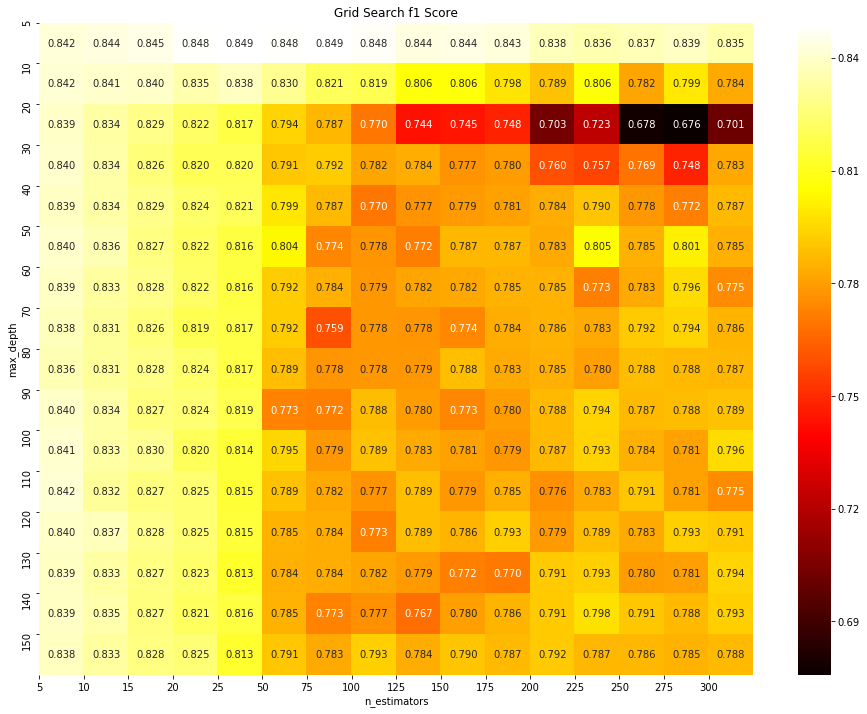

In [43]:
scores = model.cv_results_['mean_test_score'].reshape(len(base_learners),len(depth))

plt.figure(figsize=(16, 12))
sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=base_learners, yticklabels=depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.xticks(np.arange(len(base_learners)), base_learners)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

Accuracy of the model at optimal hyperparameter estimator = 25 is:  73.266667%
Confusion matrix for the model is:


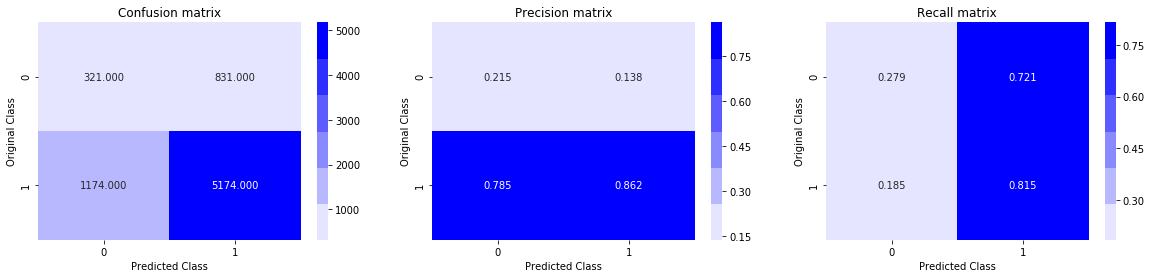

f1 score value for   the model is: 0.7326666666666668
precision score  for   the model is: 0.8616153205661948


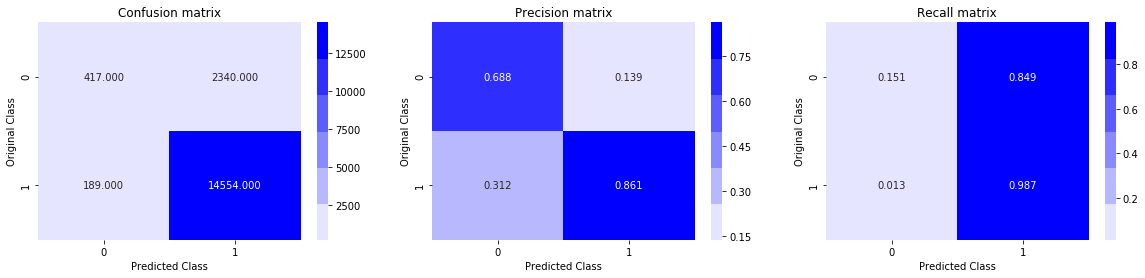

Accuracy of the model at optimal hyperparameter estimator = 25 is:  85.548571%
f1 score value for   the model is: 0.8554857142857143
precision score  for   the model is: 0.8614892861370901


In [44]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
gb = GradientBoostingClassifier(n_estimators=optimal_learners, max_depth=optimal_depth, max_features='sqrt', subsample=0.1)
gb.fit(X_train_vec,Y_train)
Y_pred = gb.predict(X_test_vec)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_test_accuracy))
print('Confusion matrix for the model is:')
plot_confusion_matrix(Y_test, Y_pred)
f1score= f1_score(Y_test, Y_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = gb.predict(X_train_vec)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter estimator = %d is:  %f%%' % (optimal_learners,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='micro')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive' )
print('precision score  for   the model is: %s'% precisionscore)

In [49]:
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words','Bag of Words','TFIDF ','TFIDF ','avg w2v','avg w2vw','TFIDF weighted word2vec','TFIDF weighted word2vec' ]
model=['Random Forest(RF)  ','Gradient Boosting Decision Tree','Random Forest(RF)  ','Gradient Boosting Decision Tree','Random Forest(RF)  ','Gradient Boosting Decision Tree','Random Forest(RF)  ','Gradient Boosting Decision Tree',]



baselearners =[10,300,10,275,200,75,225,25]
depth=[120,20,130,10,80,5,130,5]
accuracy = [87.77,86.96,87.94,88.28,86.84,86.69,81.02,73.26]
F1score= [0.8631,0.8635,0.8578,0.8708,0.8684,0.8484,0.8102,0.7326]
precision=[0.8965,0.9083,0.8879,0.9026,0.8753,0.8873,0.8553,0.8616]
numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("Method",model)
ptable.add_column("base learners",baselearners)
ptable.add_column("depth",depth)
ptable.add_column("accuracy",accuracy)
ptable.add_column("f1score",F1score)
ptable.add_column("precision",precision)

# Printing the Table
print(ptable)

+-------+-------------------------+---------------------------------+---------------+-------+----------+---------+-----------+
| S.NO. |          MODEL          |              Method             | base learners | depth | accuracy | f1score | precision |
+-------+-------------------------+---------------------------------+---------------+-------+----------+---------+-----------+
|   1   |       Bag of Words      |       Random Forest(RF)         |       10      |  120  |  87.77   |  0.8631 |   0.8965  |
|   2   |       Bag of Words      | Gradient Boosting Decision Tree |      300      |   20  |  86.96   |  0.8635 |   0.9083  |
|   3   |          TFIDF          |       Random Forest(RF)         |       10      |  130  |  87.94   |  0.8578 |   0.8879  |
|   4   |          TFIDF          | Gradient Boosting Decision Tree |      275      |   10  |  88.28   |  0.8708 |   0.9026  |
|   5   |         avg w2v         |       Random Forest(RF)         |      200      |   80  |  86.84   |  0.868